In [3]:
from sklearn.metrics import f1_score, confusion_matrix, make_scorer, accuracy_score, recall_score
from sklearn.model_selection import cross_val_score, train_test_split, cross_validate
from fairlearn.metrics import (
    count,
    selection_rate,
    equalized_odds_difference,
    false_positive_rate,
    false_negative_rate,
    demographic_parity_difference,
    MetricFrame,
    true_negative_rate,
    true_positive_rate
)

from fairlearn.datasets import fetch_adult
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from metrics import equality_opportunity_difference, predictive_equality_difference


import numpy as np
import optuna
import tqdm as notebook_tqdm

import dill
import optuna
import plotly

/home/azucena/miniconda3/envs/fairenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## One simulation

In [2]:
data = fetch_adult(as_frame=True)
X_raw = data.data
y = (data.target == ">50K") * 1
A = X_raw["sex"]

(X_train, X_test, y_train, y_test, A_train, A_test) = train_test_split(
    X_raw, y, A, test_size=0.8, random_state=0, stratify=y
)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
A_train = A_train.reset_index(drop=True)
A_test = A_test.reset_index(drop=True)

numeric_transformer = Pipeline(
    steps=[
        ("impute", SimpleImputer()),
        ("scaler", StandardScaler()),
    ]
)
categorical_transformer = Pipeline(
    [
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore")),
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, selector(dtype_exclude="category")),
        ("cat", categorical_transformer, selector(dtype_include="category")),
    ]
)

pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        (
            "classifier",
            LGBMClassifier(n_jobs=-1),
        ),
    ]
)

/home/azucena/miniconda3/envs/fairenv/lib/python3.10/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [3]:

#file_name = 'f1-dpd-lgbm-motpe-succesivehalving-100trials.pkl'
#file_name = 'f1-tpr-lgbm-motpe-succesivehalving-100trials-1sim.pkl'
file_name = 'recall-fpr-lgbm-motpe-succesivehalving-100trials-1sim.pkl'
with open(file_name, 'rb') as in_strm:
    results = dill.load(in_strm)

In [4]:

optuna.visualization.plot_pareto_front(results[0], target_names=["fair_metric", "f1_score"], include_dominated_trials = False)

In [5]:
optuna.visualization.plot_pareto_front(results[0], target_names=["fair_metric", "f1_score"], include_dominated_trials = True)

In [6]:
#results_df.head(2)

/tmp/ipykernel_58583/3554850095.py:1: ExperimentalWarning:

plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.



<Axes: title={'center': 'Hyperparameter Importances'}, xlabel="Importance for ['Fair metric']", ylabel='Hyperparameter'>

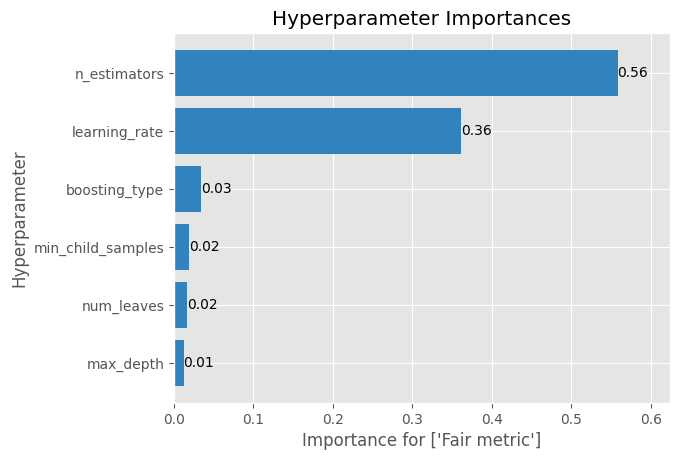

In [7]:
optuna.visualization.matplotlib.plot_param_importances(results[0], target = lambda t: t.values[0], target_name = ["Fair metric"])

/tmp/ipykernel_58583/1945804371.py:1: ExperimentalWarning:

plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.



<Axes: title={'center': 'Hyperparameter Importances'}, xlabel="Importance for ['Model metric']", ylabel='Hyperparameter'>

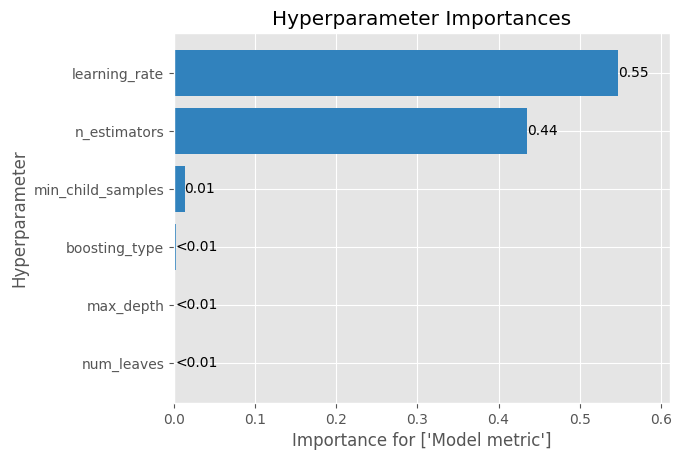

In [8]:
optuna.visualization.matplotlib.plot_param_importances(results[0], target = lambda t: t.values[1], target_name = ["Model metric"])

In [13]:
import matplotlib.pyplot as plt
results_df = results[0].trials_dataframe()

In [6]:
def equality_opportunity_difference(y_true, y_pred, sensitive_features):
    return MetricFrame(metrics=true_positive_rate, y_true=y_true, y_pred=y_pred, sensitive_features=sensitive_features).difference()

def predictive_equality_difference(y_true, y_pred, sensitive_features):
    return MetricFrame(metrics=false_positive_rate, y_true=y_true, y_pred=y_pred, sensitive_features=sensitive_features).difference()


fair_metric = []
model_metric = []
for i in range(len(results[0].best_trials)):
    best_params = {key.replace('lgbm_',''):value for key, value in results[0].best_trials[i].params.items()}
    pipeline['classifier'].set_params(**best_params)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)  
    
    fair_metric.append(np.abs(predictive_equality_difference(y_test, y_pred, sensitive_features=A_test)))
    #fair_metric.append(np.abs(demographic_parity_difference(y_test, y_pred, sensitive_features=A_test)))
    model_metric.append(recall_score(y_test, y_pred))

In [9]:
fair_metric_train = [results[0].best_trials[i].values[0] for i in range(len(results[0].best_trials))]
model_metric_train = [results[0].best_trials[i].values[1] for i in range(len(results[0].best_trials))]

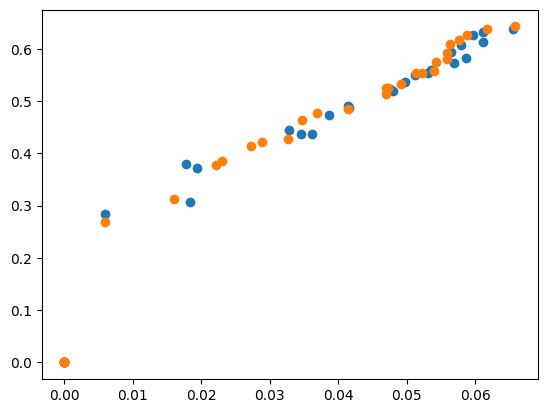

In [14]:
plt.scatter(fair_metric, model_metric)
plt.scatter(fair_metric_train, model_metric_train)

In [15]:
fairness_metrics = list(zip(fair_metric_train, fair_metric))
fairness_metrics_ = sorted(fairness_metrics, key = lambda x: x[0])
#fairness_metrics_

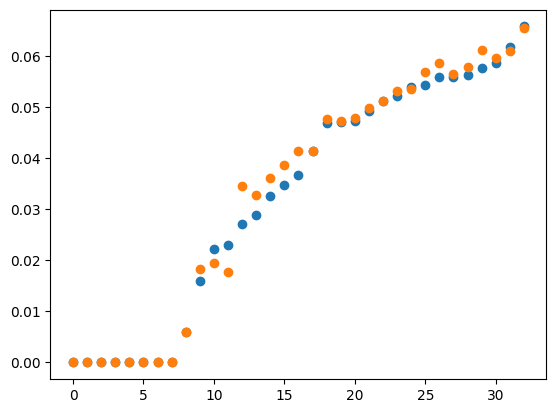

In [16]:
plt.scatter(range(len(fair_metric_train)),list(zip(*fairness_metrics_))[0])
plt.scatter(range(len(fair_metric_train)), list(zip(*fairness_metrics_))[1])

In [17]:
model_metrics = list(zip(model_metric_train, model_metric))
model_metrics_ = sorted(model_metrics, key = lambda x: x[0])

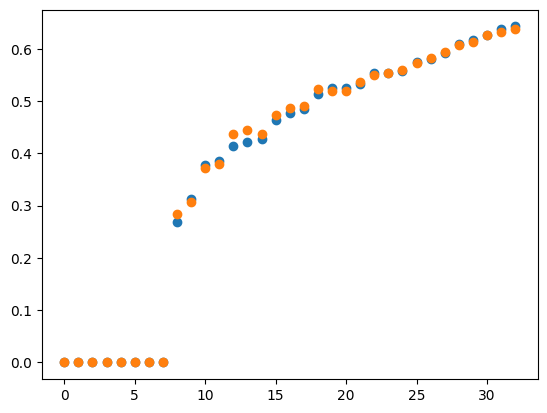

In [18]:
plt.scatter(range(len(fair_metric_train)),list(zip(*model_metrics_))[0])
plt.scatter(range(len(fair_metric_train)), list(zip(*model_metrics_))[1])

In [28]:
n = 1
best_params = {key.replace('lgbm_',''):value for key, value in results.best_trials[n].params.items()}
pipeline['classifier'].set_params(**best_params)

LGBMClassifier(learning_rate=0.46799607752301065, max_depth=2,
               min_child_samples=65, n_estimators=2261, num_leaves=359)

In [29]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

In [30]:
fair_value = np.abs(equalized_odds_difference(y_test, y_pred, sensitive_features=A_test))
model_value = f1_score(y_test, y_pred) 
print(fair_value)
print(model_value)

0.08491853498663993
0.6986259541984733


## Several Simulations

In [4]:
file_name = 'recall-fpr-lgbm-motpe-succesivehalving-100trials-4sim.pkl'
with open(file_name, 'rb') as in_strm:
    results = dill.load(in_strm)

In [5]:
data = fetch_adult(as_frame=True)
X_raw = data.data
y = (data.target == ">50K") * 1
A = X_raw["sex"]

numeric_transformer = Pipeline(
    steps=[
        ("impute", SimpleImputer()),
        ("scaler", StandardScaler()),
    ]
)
categorical_transformer = Pipeline(
    [
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore")),
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, selector(dtype_exclude="category")),
        ("cat", categorical_transformer, selector(dtype_include="category")),
    ]
)

pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        (
            "classifier",
            LGBMClassifier(n_jobs=-1),
        ),
    ]
)

/home/azucena/miniconda3/envs/fairenv/lib/python3.10/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [12]:
fair_sim_u = []
model_sim_u = []
fair_sim = []
model_sim = []
res_fair_sim = []
res_model_sim = []
for sim_n,res in enumerate(results):
    print(sim_n)
    (X_train, X_test, y_train, y_test, A_train, A_test) = train_test_split(
    X_raw, y, A, test_size=0.8, stratify=y, random_state=sim_n
    )

    X_train = X_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)
    A_train = A_train.reset_index(drop=True)
    A_test = A_test.reset_index(drop=True)

    pipeline.steps.pop(1)
    pipeline.steps.insert(1,('classifier',LGBMClassifier(n_jobs=-1)))
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    fair_sim_u.append((np.abs(predictive_equality_difference(y_test, y_pred, sensitive_features=A_test))))
    model_sim_u.append(recall_score(y_test, y_pred))

    fair_value = []
    model_value = []
    res_fair_value = []
    res_model_value = []
    for i in range(len(res.best_trials)):
        best_params = {key.replace('lgbm_',''):value for key, value in res.best_trials[i].params.items()}
        pipeline['classifier'].set_params(**best_params)
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)  
        res_fair_value.append(res.best_trials[i].values[0])
        res_model_value.append(res.best_trials[i].values[1])
        fair_value.append(np.abs(predictive_equality_difference(y_test, y_pred, sensitive_features=A_test)))
        model_value.append(recall_score(y_test, y_pred))

    res_fair_sim.append(res_fair_value)
    res_model_sim.append(res_model_value)
    fair_sim.append(fair_value)
    model_sim.append(model_value)


0
1
2


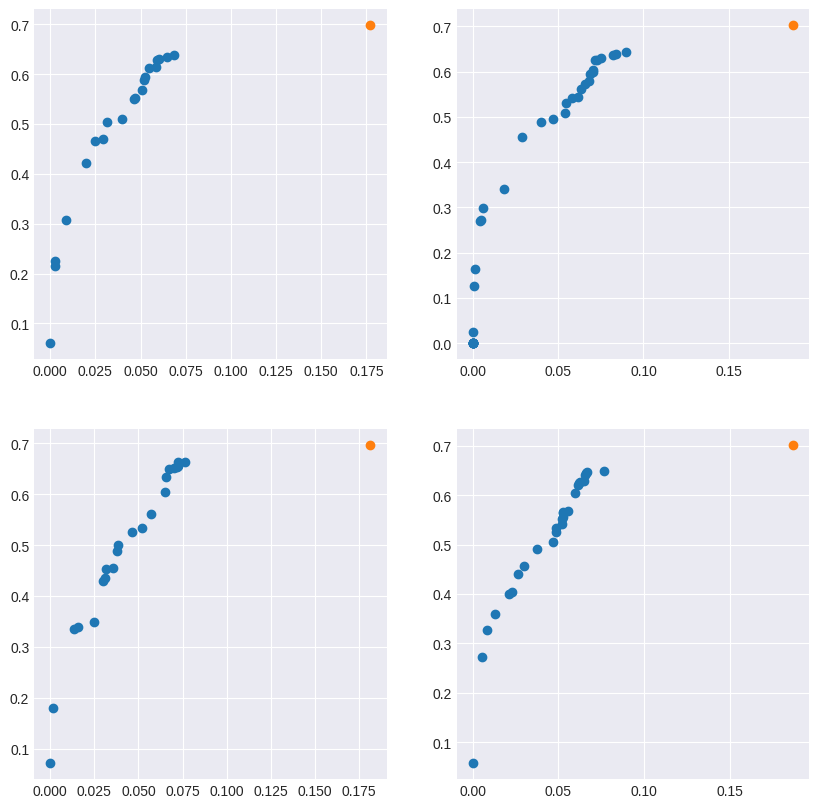

In [9]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-darkgrid')

rows = 2
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(10,10))
for i,ax in zip(range(len(res_fair_sim)),axes.ravel()):
    ax.scatter(res_fair_sim[i], res_model_sim[i])
    ax.scatter(fair_sim_u[i], model_sim_u[i])
    #order = results[i].F[:,0].argsort()
    #ax.scatter(range(len(fair_sim[i])), results[i].F[order,0])
    #ax.scatter(fair_sim[i], model_sim[i])
    #ax.scatter(fair_sim_u[i], model_sim_u[i])

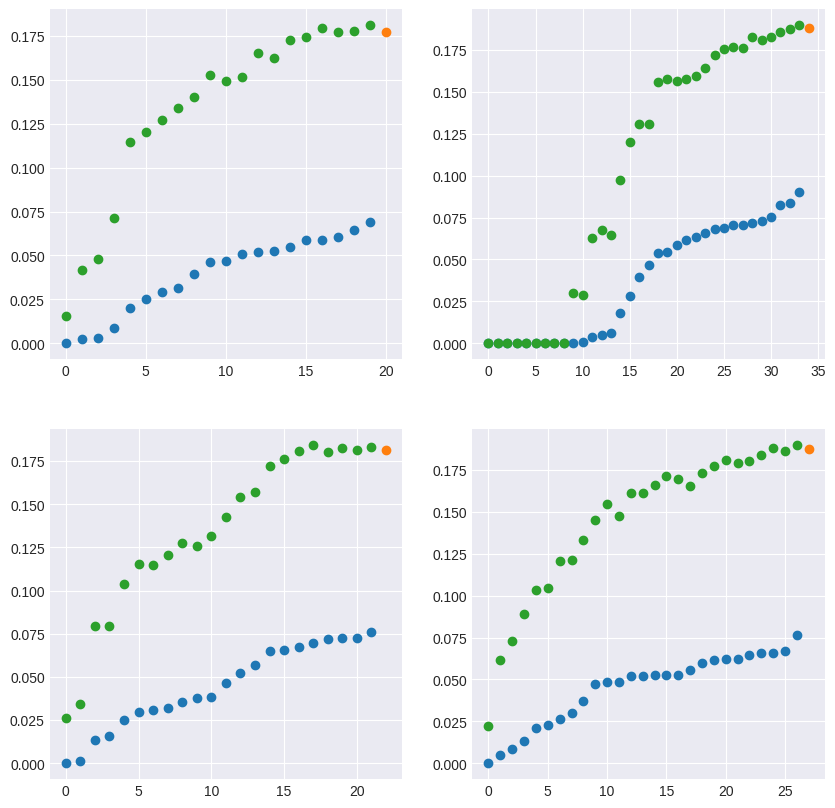

In [10]:
plt.style.use('seaborn-v0_8-darkgrid')
rows = 2
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(10,10))
for i,ax in zip(range(len(res_fair_sim)),axes.ravel()):
    fairness_metrics = list(zip(res_fair_sim[i], fair_sim[i]))
    fairness_metrics_ = sorted(fairness_metrics, key = lambda x: x[0])
    ax.scatter(range(len(res_fair_sim[i])), list(zip(*fairness_metrics_))[0])
    ax.scatter(len(res_fair_sim[i]), fair_sim_u[i])
    ax.scatter(range(len(res_fair_sim[i])), list(zip(*fairness_metrics_))[1])

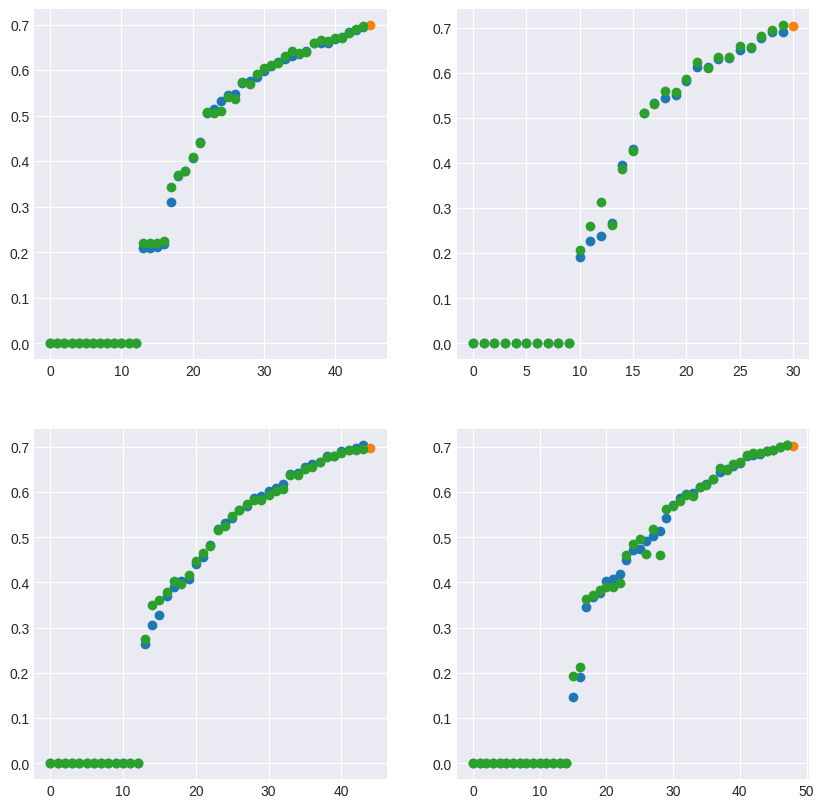

In [38]:
rows = 2
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(10,10))
for i,ax in zip(range(len(res_model_sim)),axes.ravel()):
    performance_metrics = list(zip(res_model_sim[i], model_sim[i]))
    performance_metrics_ = sorted(performance_metrics, key = lambda x: x[0])
    ax.scatter(range(len(res_model_sim[i])), list(zip(*performance_metrics_))[0])
    ax.scatter(len(res_model_sim[i]), model_sim_u[i])
    ax.scatter(range(len(res_model_sim[i])), list(zip(*performance_metrics_))[1])

In [43]:
np.array(list(zip(*fairness_metrics_))[0])-np.array(list(zip(*fairness_metrics_))[1])

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -0.00372159, -0.00372159,
       -0.00356522, -0.00338669, -0.01241966, -0.00803278, -0.00738235,
       -0.0080663 , -0.00639008, -0.00957663, -0.00114971,  0.00580643,
       -0.00485731,  0.00079943, -0.01006313, -0.00615676, -0.0142069 ,
       -0.00962224, -0.01318457, -0.00541229, -0.01309264, -0.00936273,
       -0.01335117, -0.0123143 , -0.01009635, -0.01394051, -0.01136542,
       -0.00891727, -0.00925434, -0.01037521, -0.01167041, -0.01453386])

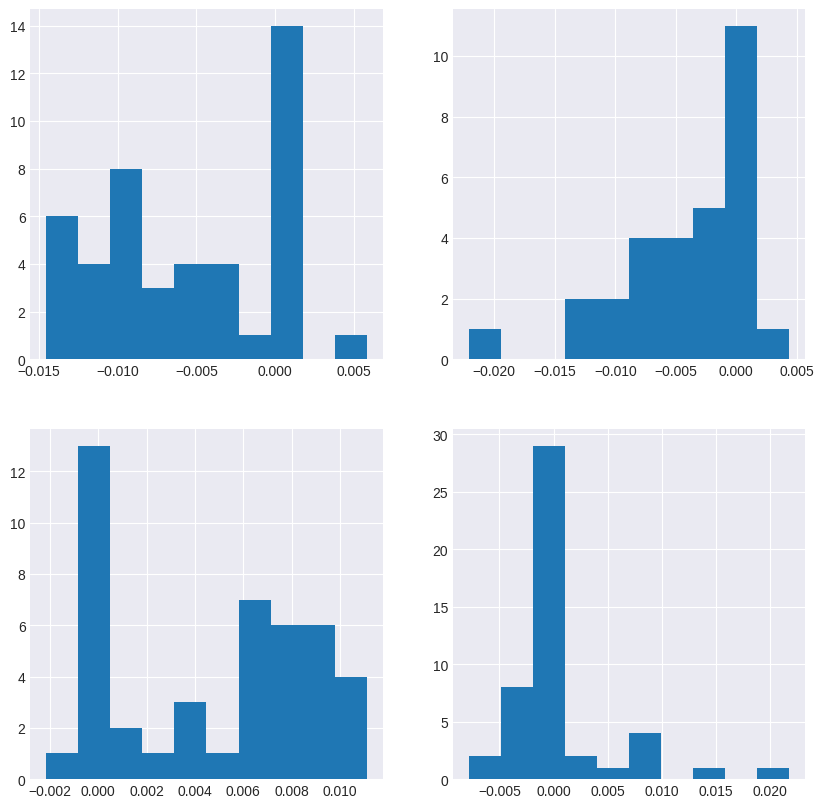

In [44]:
fig, axes = plt.subplots(rows, cols, figsize=(10,10))
for i,ax in zip(range(len(fair_sim)),axes.ravel()):
    fairness_metrics = list(zip(res_fair_sim[i], fair_sim[i]))
    fairness_metrics_ = sorted(fairness_metrics, key = lambda x: x[0])
    fair_residuals = np.array(list(zip(*fairness_metrics_))[0])-np.array(list(zip(*fairness_metrics_))[1])
    ax.hist(fair_residuals)

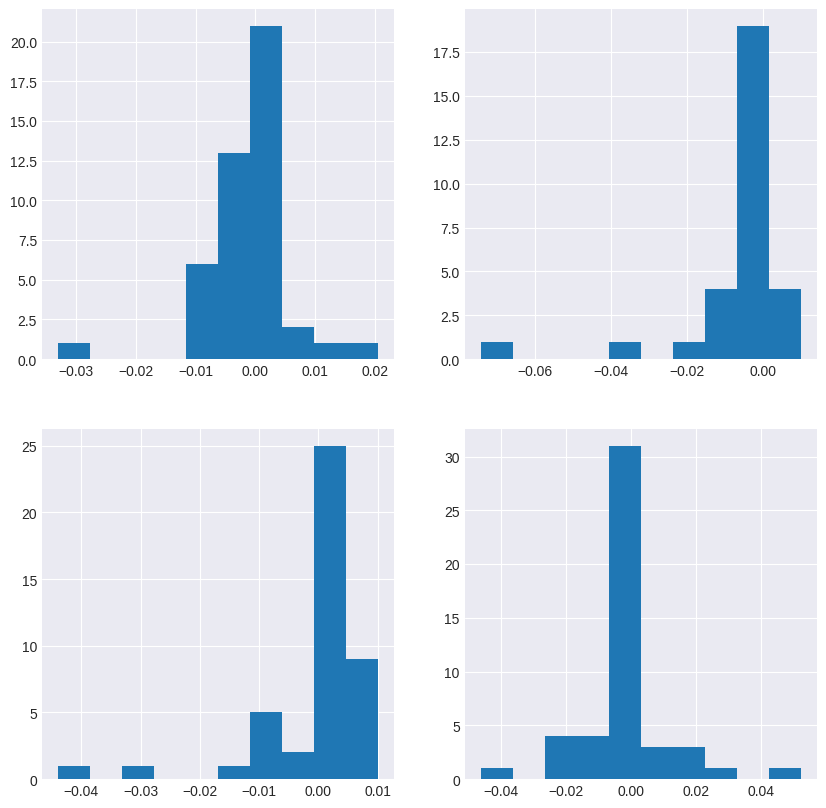

In [46]:
fig, axes = plt.subplots(rows, cols, figsize=(10,10))
for i,ax in zip(range(len(fair_sim)),axes.ravel()):
    model_metrics = list(zip(res_model_sim[i], model_sim[i]))
    model_metrics_ = sorted(model_metrics, key = lambda x: x[0])
    fair_residuals = np.array(list(zip(*model_metrics_))[0])-np.array(list(zip(*model_metrics_))[1])
    ax.hist(fair_residuals)

## Different Models

In [41]:
file_name = 'recall-fpr-models-motpe-succesivehalving-100trials-4sim.pkl'
with open(file_name, 'rb') as in_strm:
    results = dill.load(in_strm)

In [42]:
data = fetch_adult(as_frame=True)
X_raw = data.data
y = (data.target == ">50K") * 1
A = X_raw["sex"]


numeric_transformer = Pipeline(
    steps=[
        ("impute", SimpleImputer()),
        ("scaler", StandardScaler()),
    ]
)
categorical_transformer = Pipeline(
    [
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore")),
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, selector(dtype_exclude="category")),
        ("cat", categorical_transformer, selector(dtype_include="category")),
    ]
)

pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        (
            "classifier",
            LGBMClassifier(n_jobs=-1),
        ),
    ]
)

/home/avasquez/miniconda3/envs/fairenv/lib/python3.10/site-packages/sklearn/datasets/_openml.py:968: FutureWarning:

The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.



In [57]:
import re

fair_sim_u = []
model_sim_u = []
fair_sim = []
model_sim = []
res_fair_sim = []
res_model_sim = []
color_train_value = []
color_test_value = []
models = [LogisticRegression(), RandomForestClassifier(), GradientBoostingClassifier(), LGBMClassifier()]
#fairness_metric = demographic_parity_difference()
for sim_n,res in enumerate(results):
    print(sim_n)
    (X_train, X_test, y_train, y_test, A_train, A_test) = train_test_split(
    X_raw, y, A, test_size=0.8, stratify=y, random_state=sim_n
    )

    X_train = X_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)
    A_train = A_train.reset_index(drop=True)
    A_test = A_test.reset_index(drop=True)

    fair_sim_u_aux = []
    model_sim_u_aux = []
    for model in models:
        pipeline.steps.pop(1)
        pipeline.steps.insert(1,('classifier', model))
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        fair_sim_u_aux.append((np.abs(predictive_equality_difference(y_test, y_pred, sensitive_features=A_test))))
        model_sim_u_aux.append(recall_score(y_test, y_pred))
    fair_sim_u.append(fair_sim_u_aux)
    model_sim_u.append(model_sim_u_aux)

    fair_value = []
    model_value = []
    res_fair_value = []
    res_model_value = []
    color_train = []
    color_test = []
    for i in range(len(res.best_trials)):
        best_params = {re.sub('^[a-z]+_','',key):value for key, value in res.best_trials[i].params.items()}
        pipeline.steps.pop(1)
        classifier_name = best_params.pop('classifier')
        if classifier_name == "logit": 
            pipeline.steps.insert(1,('classifier', LogisticRegression()))
            color_train.append('#4169E1') #blue
            color_test.append("#87CEFA")
        elif classifier_name =="RF":
            pipeline.steps.insert(1,('classifier', RandomForestClassifier()))
            color_train.append('#3CB371') #green
            color_test.append('#90EE90')
        elif classifier_name =="LGBM":
            pipeline.steps.insert(1,('classifier', LGBMClassifier()))
            color_train.append('#CD5C5C') #coral
            color_test.append('#F08080')
        elif classifier_name =="GBM":
            pipeline.steps.insert(1,('classifier', GradientBoostingClassifier()))
            color_train.append('#6A5ACD') #purple
            color_test.append('#9370DB')
        pipeline['classifier'].set_params(**best_params)
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)  
        res_fair_value.append(res.best_trials[i].values[0])
        res_model_value.append(res.best_trials[i].values[1])
        fair_value.append(np.abs(predictive_equality_difference(y_test, y_pred, sensitive_features=A_test)))
        model_value.append(recall_score(y_test, y_pred))

    color_train_value.append(color_train)
    color_test_value.append(color_test)
    res_fair_sim.append(res_fair_value)
    res_model_sim.append(res_model_value)
    fair_sim.append(fair_value)
    model_sim.append(model_value)


0


/home/avasquez/miniconda3/envs/fairenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



1


/home/avasquez/miniconda3/envs/fairenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



2


/home/avasquez/miniconda3/envs/fairenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



3


/home/avasquez/miniconda3/envs/fairenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



4


/home/avasquez/miniconda3/envs/fairenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



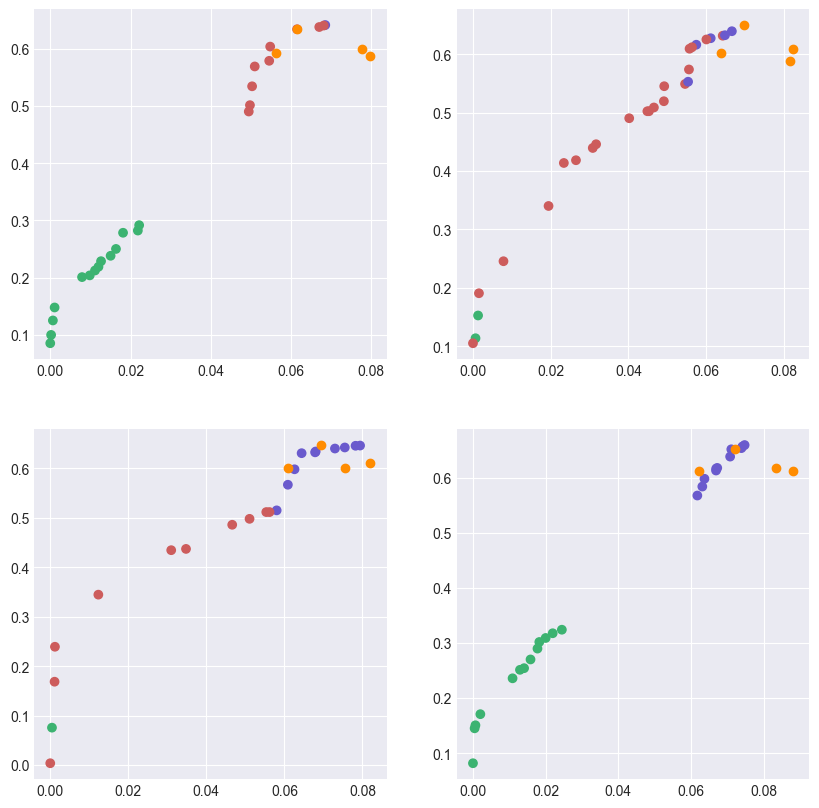

In [58]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-darkgrid')

rows = 2
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(10,10))
for i,ax in zip(range(len(res_fair_sim)),axes.ravel()):
    ax.scatter(res_fair_sim[i], res_model_sim[i], c = color_train_value[i])
    ax.scatter(fair_sim_u[i], model_sim_u[i], c = 'darkorange')
    #order = results[i].F[:,0].argsort()
    #ax.scatter(range(len(fair_sim[i])), results[i].F[order,0])
    #ax.scatter(fair_sim[i], model_sim[i])
    #ax.scatter(fair_sim_u[i], model_sim_u[i])

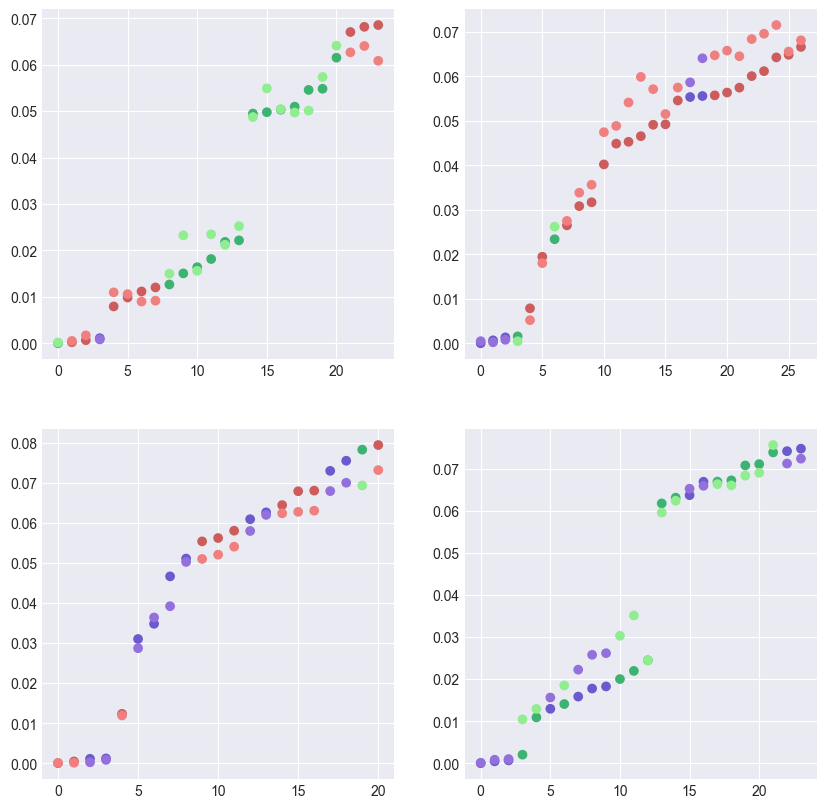

In [59]:
plt.style.use('seaborn-v0_8-darkgrid')
rows = 2
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(10,10))
for i,ax in zip(range(len(res_fair_sim)),axes.ravel()):
    fairness_metrics = list(zip(res_fair_sim[i], fair_sim[i]))
    fairness_metrics_ = sorted(fairness_metrics, key = lambda x: x[0])
    ax.scatter(range(len(res_fair_sim[i])), list(zip(*fairness_metrics_))[0], c = color_train_value[i])
    #ax.scatter(len(res_fair_sim[i]*4), fair_sim_u[i])
    ax.scatter(range(len(res_fair_sim[i])), list(zip(*fairness_metrics_))[1], c = color_test_value[i])

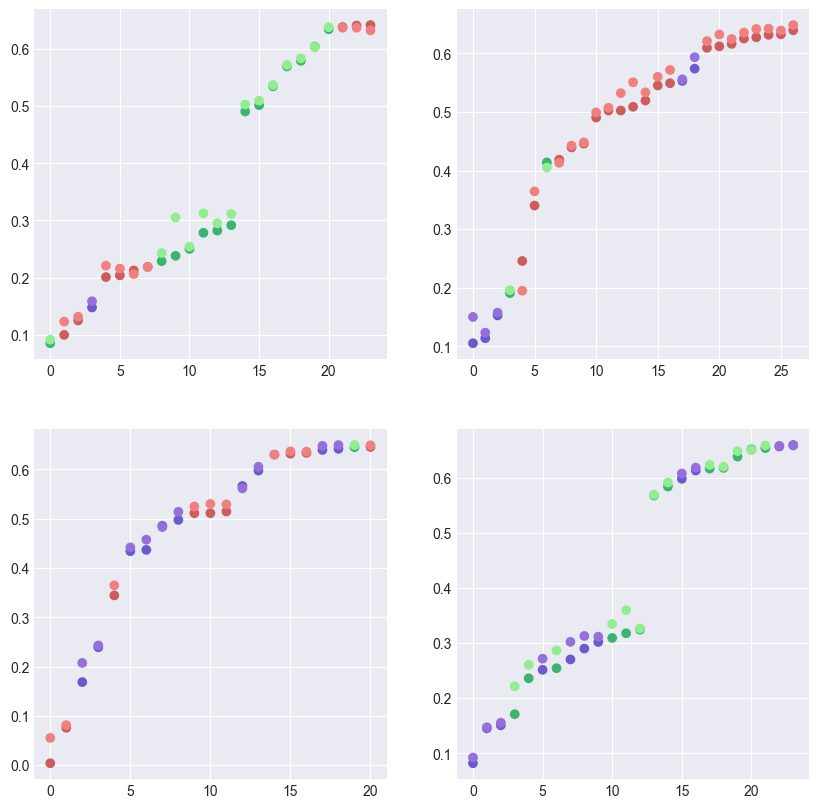

In [60]:
rows = 2
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(10,10))
for i,ax in zip(range(len(res_model_sim)),axes.ravel()):
    performance_metrics = list(zip(res_model_sim[i], model_sim[i]))
    performance_metrics_ = sorted(performance_metrics, key = lambda x: x[0])
    ax.scatter(range(len(res_model_sim[i])), list(zip(*performance_metrics_))[0], c = color_train_value[i])
    #ax.scatter(len(res_model_sim[i]), model_sim_u[i])
    ax.scatter(range(len(res_model_sim[i])), list(zip(*performance_metrics_))[1], c = color_test_value[i])

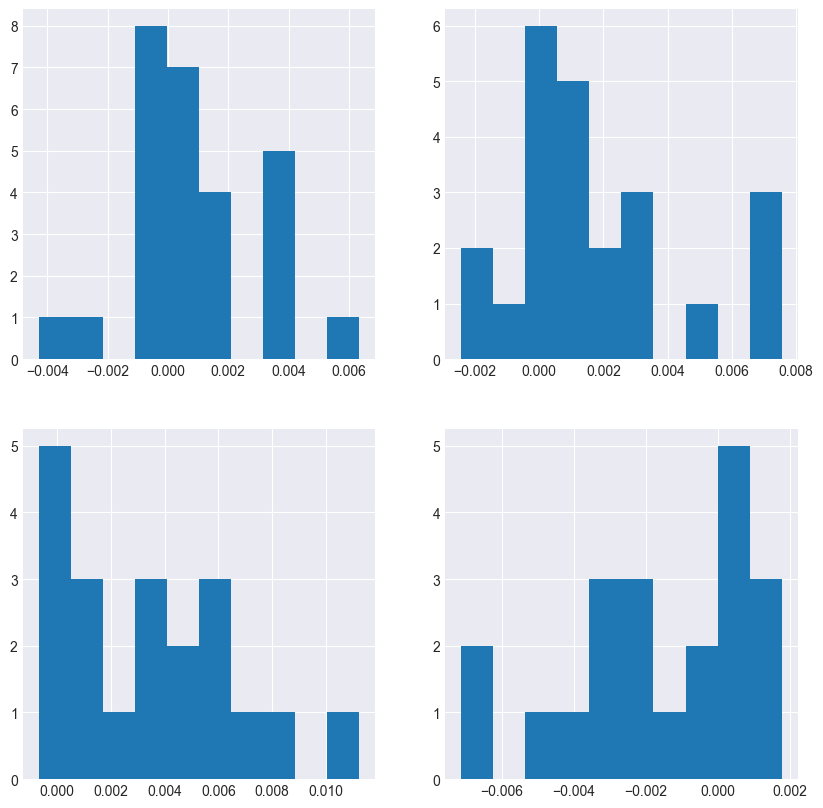

In [36]:
fig, axes = plt.subplots(rows, cols, figsize=(10,10))
for i,ax in zip(range(len(fair_sim)),axes.ravel()):
    fairness_metrics = list(zip(res_fair_sim[i], fair_sim[i]))
    fairness_metrics_ = sorted(fairness_metrics, key = lambda x: x[0])
    fair_residuals = np.array(list(zip(*fairness_metrics_))[0])-np.array(list(zip(*fairness_metrics_))[1])
    ax.hist(fair_residuals)

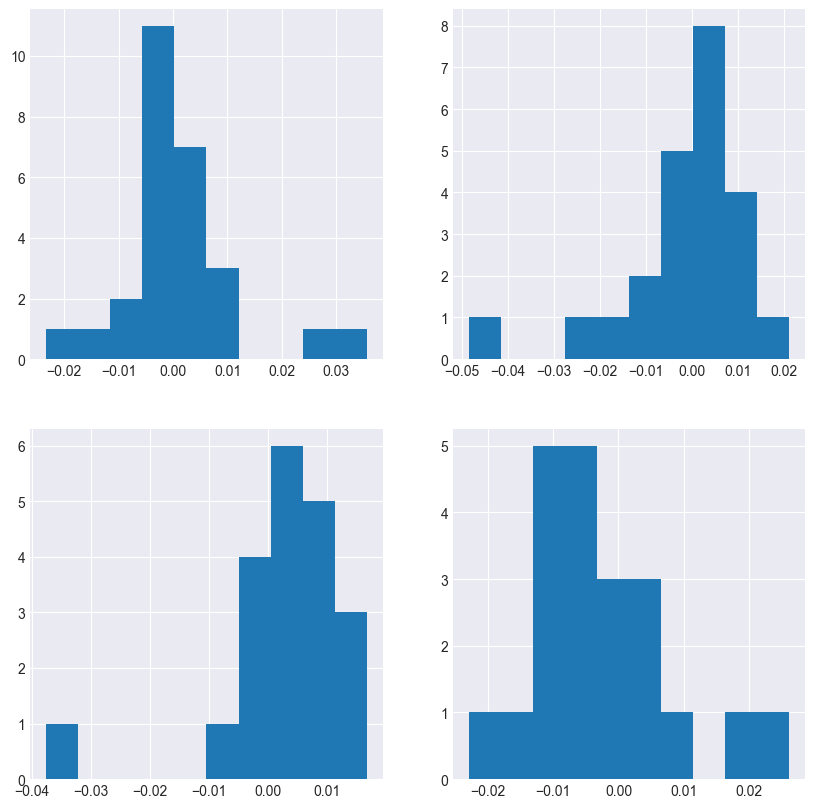

In [37]:
fig, axes = plt.subplots(rows, cols, figsize=(10,10))
for i,ax in zip(range(len(fair_sim)),axes.ravel()):
    model_metrics = list(zip(res_model_sim[i], model_sim[i]))
    model_metrics_ = sorted(model_metrics, key = lambda x: x[0])
    fair_residuals = np.array(list(zip(*model_metrics_))[0])-np.array(list(zip(*model_metrics_))[1])
    ax.hist(fair_residuals)

In [40]:
optuna.visualization.plot_pareto_front(results[0], target_names=["fair_metric", "f1_score"], include_dominated_trials = False)